# Train on a FiftyOne dataset

## 1. Download data with fiftyone

In [1]:
import json
import cv2
from tqdm import tqdm
import torch
import numpy as np

from PIL import Image
import fiftyone as fo
import fiftyone.zoo as foz
import os.path as osp
from mmengine.dataset import BaseDataset

import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import SGD
from torch.utils.data import DataLoader

from mmengine.evaluator import BaseMetric
from mmengine.model import BaseModel
from mmengine.runner import Runner

from mmengine import Config
from mmengine.device import get_device
from mmengine.infer import BaseInferencer
from mmengine.registry import INFERENCERS, MODELS
from mmengine.visualization import Visualizer
import fiftyone.brain as fob
from fiftyone import ViewField as VF

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
0
GeForce GTX 1650 with Max-Q Design
10.2


In [3]:
print(foz.list_zoo_datasets())

['activitynet-100', 'activitynet-200', 'bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'fiw', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kinetics-400', 'kinetics-600', 'kinetics-700', 'kinetics-700-2020', 'kitti', 'kitti-multiview', 'lfw', 'mnist', 'open-images-v6', 'open-images-v7', 'quickstart', 'quickstart-geo', 'quickstart-groups', 'quickstart-video', 'sama-coco', 'ucf101', 'voc-2007', 'voc-2012']


Split 'train' already downloaded
Split 'test' already downloaded
Loading 'cifar10' split 'train'
 100% |█████████████| 50000/50000 [22.0s elapsed, 0s remaining, 2.3K samples/s]      
Loading 'cifar10' split 'test'
 100% |█████████████| 10000/10000 [4.6s elapsed, 0s remaining, 2.1K samples/s]      
Dataset 'cifar10' created
Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



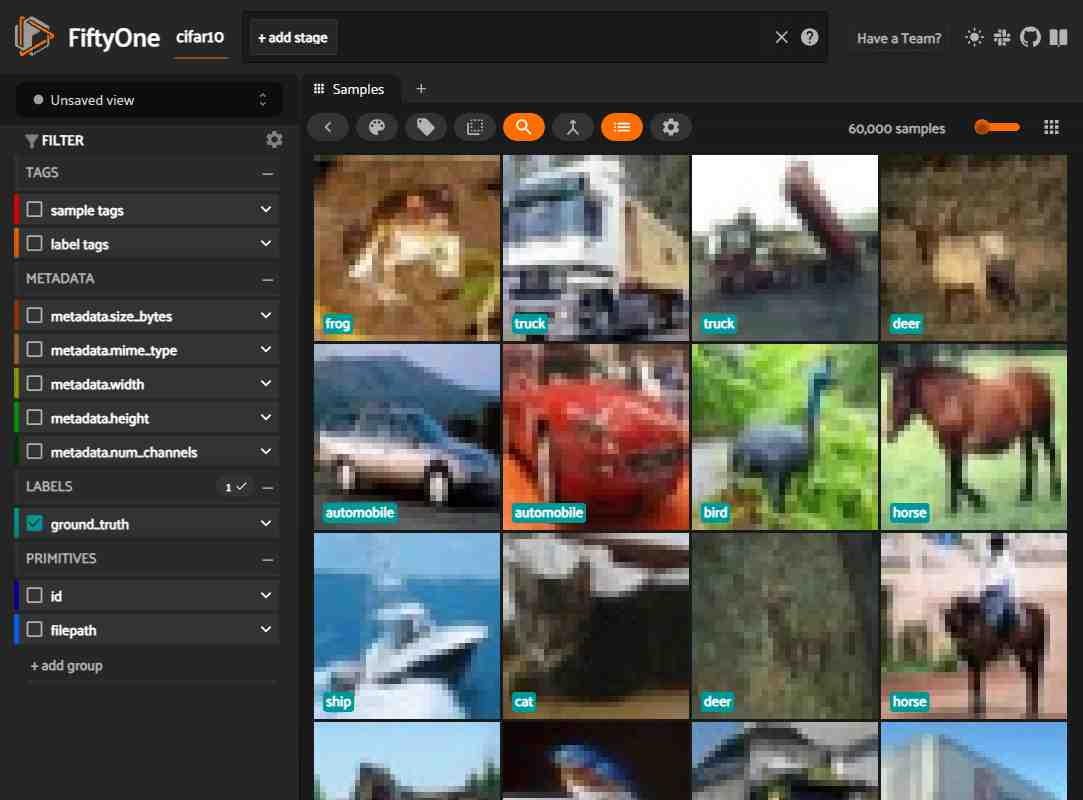


Could not connect session, trying again in 10 seconds

Notebook sessions cannot wait


In [4]:
fifty_one_data_dir = 'D:\\fiftyone/cifar10'
dataset = foz.load_zoo_dataset("cifar10", dataset_dir=fifty_one_data_dir)
session = fo.launch_app(dataset)
session.wait()

## 2. Custom dataset with MMEngine

In [5]:
def convert_json_format(json_path, train=True):
    with open(json_path, 'r') as f:
        c = json.load(f)
        metainfo = {'classes': c['classes']}
        data_list = []
        for p, l in c['labels'].items():
            tmp = {
                'img_path': osp.join(osp.dirname(json_path), 'data', p + '.jpg'),
                'img_label': l
            }
            data_list.append(tmp)
    new_c = {
        'metainfo': metainfo,
        'data_list': data_list
    }
    if train:
        _path = osp.join(osp.dirname(json_path), 'train.json')
    else:
        _path = osp.join(osp.dirname(json_path), 'test.json')
    with open(_path, 'w') as f:
        json.dump(new_c, f)
    return _path

In [6]:
train_json_path = convert_json_format('D:\\fiftyone/cifar10/train/labels.json')
train_json_path

'D:\\fiftyone/cifar10/train\\train.json'

In [7]:
test_json_path = convert_json_format('D:\\fiftyone/cifar10/test/labels.json', train=False)
test_json_path

'D:\\fiftyone/cifar10/test\\test.json'

In [8]:
class CifarDataset(BaseDataset):

    # 以上面标注文件为例，在这里 raw_data_info 代表 `data_list` 对应列表里的某个字典：
    # {
    #    'img_path': "xxx/xxx_0.jpg",
    #    'img_label': 0,
    #    ...
    # }
    def parse_data_info(self, raw_data_info):
        data_info = raw_data_info
        img_prefix = self.data_prefix.get('img_path', None)
        if img_prefix is not None:
            data_info['img_path'] = osp.join(
                img_prefix, data_info['img_path'])
        return data_info

class LoadImage:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, results):
        results['img'] = self._transform(Image.fromarray(cv2.imread(results['img_path'])))
        # results.pop('img_path', None)
        return results

    def _transform(self, img):
        if self.transform is not None:
            img = self.transform(img)
        return img

class ParseImage:

    def __call__(self, results):
        results['img_shape'] = results['img'].shape
        return results
norm_cfg = dict(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201])

train_trans = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(**norm_cfg)
    ]
)

test_trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(**norm_cfg)])

train_pipeline = [
    LoadImage(transform=train_trans),
    ParseImage(),
]

test_pipeline = [
    LoadImage(test_trans),
    ParseImage(),
]

In [9]:
train_dataset = CifarDataset(
    data_root='D:\\fiftyone/cifar10/train',
    # data_prefix=dict(img_path='D:\\fiftyone/cifar10/train/data'),
    ann_file=train_json_path,
    pipeline=train_pipeline
)

In [10]:
train_dataset.metainfo

{'classes': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']}

In [11]:
train_dataset.get_data_info(0)

{'img_path': 'D:\\fiftyone/cifar10/train\\data\\000001.jpg',
 'img_label': 6,
 'sample_idx': 0}

In [12]:
len(train_dataset)

50000

In [13]:
train_dataset[0]

{'img_path': 'D:\\fiftyone/cifar10/train\\data\\000001.jpg',
 'img_label': 6,
 'sample_idx': 0,
 'img': tensor([[[-2.4307, -2.4307, -2.4307,  ..., -1.7706, -1.6736, -1.7512],
          [-2.4307, -2.4307, -2.4307,  ..., -1.6930, -1.7706, -1.7706],
          [-2.4307, -2.4307, -2.4307,  ..., -1.7318, -1.6153, -1.5182],
          ...,
          [-2.4307, -2.4307, -2.4307,  ..., -2.4307, -2.4307, -2.4307],
          [-2.4307, -2.4307, -2.4307,  ..., -2.4307, -2.4307, -2.4307],
          [-2.4307, -2.4307, -2.4307,  ..., -2.4307, -2.4307, -2.4307]],
 
         [[-2.4221, -2.4221, -2.4221,  ..., -0.9835, -0.9638, -1.1018],
          [-2.4221, -2.4221, -2.4221,  ..., -0.8456, -0.9244, -0.9835],
          [-2.4221, -2.4221, -2.4221,  ..., -0.8259, -0.7274, -0.6682],
          ...,
          [-2.4221, -2.4221, -2.4221,  ..., -2.4221, -2.4221, -2.4221],
          [-2.4221, -2.4221, -2.4221,  ..., -2.4221, -2.4221, -2.4221],
          [-2.4221, -2.4221, -2.4221,  ..., -2.4221, -2.4221, -2.4221]],

In [14]:
test_dataset = CifarDataset(
    data_root='D:\\fiftyone/cifar10/test',
    # data_prefix=dict(img_path='D:\\fiftyone/cifar10/test/data'),
    ann_file=test_json_path,
    pipeline=test_pipeline,
    test_mode=True
)

In [15]:
len(test_dataset)

10000

In [16]:
train_dataloader = DataLoader(
    batch_size=500,
    shuffle=True,
    dataset=train_dataset
)

val_dataloader = DataLoader(
    batch_size=500,
    shuffle=False,
    dataset=test_dataset
)

# Define the model and train!

In [17]:
@MODELS.register_module()
class MMResNet50(BaseModel):

    def __init__(self, num_out):
        super().__init__()
        self.resnet = torchvision.models.resnet50()
        self.mod_out_features(num_out)

    def forward(self, img, img_label, mode, **args):
        x = self.resnet(img if not isinstance(img, list) else img[0])
        if mode == 'loss':
            return {'loss': F.cross_entropy(x, img_label)}
        elif mode == 'predict':
            return x, img_label
    
    def mod_out_features(self, num_out=1000):
        num_in = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Sequential(torch.nn.Linear(num_in, num_out), torch.nn.LogSoftmax(dim=1))

In [18]:
class Accuracy(BaseMetric):

    def process(self, data_batch, data_samples):
        score, gt = data_samples
        # 将一个批次的中间结果保存至 `self.results`
        self.results.append({
            'batch_size': len(gt),
            'correct': (score.argmax(dim=1) == gt).sum().cpu(),
        })

    def compute_metrics(self, results):
        total_correct = sum(item['correct'] for item in results)
        total_size = sum(item['batch_size'] for item in results)
        # 返回保存有评测指标结果的字典，其中键为指标名称
        return dict(accuracy=100 * total_correct / total_size)

In [19]:
work_dir='D:\\fiftyone\cifar10-mmengine/work_dir'
runner = Runner(
    model=MMResNet50(10),
    work_dir=work_dir,
    train_dataloader=train_dataloader,
    # 优化器包装，用于模型优化，并提供 AMP、梯度累积等附加功能
    optim_wrapper=dict(optimizer=dict(type=SGD, lr=0.001, momentum=0.9)),
    # 训练配置，例如 epoch 等
    train_cfg=dict(by_epoch=True, max_epochs=5, val_interval=1),
    val_dataloader=val_dataloader,
    val_cfg=dict(),
    val_evaluator=dict(type=Accuracy),
)

08/15 20:24:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 1065337676
    GPU 0: GeForce GTX 1650 with Max-Q Design
    CUDA_HOME: None
    GCC: n/a
    PyTorch: 1.10.0
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-genco

In [20]:
runner.train()

08/15 20:24:52 - mmengine - WARNING - The prefix is not set in metric class Accuracy.
08/15 20:24:54 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/15 20:24:54 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
08/15 20:24:54 - mmengine - INFO - Checkpoints will be saved to D:\fiftyone\cifar10-mmengine\work_dir.
08/15 20:25:08 - mmengine - INFO - Epoch(train) [1][ 10/100]  lr: 1.0000e-03  eta: 0:11:00  time: 1.3481  data_time: 0.2190  memory: 1236  loss: 2.5695
08/15 20:25:19 - mmengine - INFO - Epoch(train) [1][ 20/100]  lr: 1.0000e-03  eta: 0:09:55  time: 1.1349  data_time: 0.2081  memory: 1236  loss: 2.4753
08/15 20:25:31 - mmengine - INFO - Epoch(train) [1][ 30/100]  lr: 1.0000e-03  eta: 0:09:28  time: 1.1448  data_time: 0.2122  memory: 1236  loss: 2.4320
08/15 20:25:43 - mmengine - INFO - Epoch(train) [

MMResNet50(
  (data_preprocessor): BaseDataPreprocessor()
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

# Inference & evaluation using the trained model

In [21]:
@INFERENCERS.register_module()
class CustomInferencer(BaseInferencer):

    def _init_visualizer(self, cfg):
        """Return custom visualizer.

        The returned visualizer will be set as ``self.visualzier``.
        """
        if cfg.get('visualizer') is not None:
            visualizer = cfg.visualizer
            visualizer.setdefault('name', 'mmengine_template')
            return Visualizer.get_instance(**cfg.visualizer)
        return Visualizer(name='mmengine_template')

    def _init_pipeline(self, cfg):
        """Return a pipeline to process input data.

        The returned pipeline should be a callable object and will be set as
        ``self.visualizer``

        This default implementation will read the image and convert it to a
        Tensor with shape (C, H, W) and dtype torch.float32. Also, users can
        build the pipeline from the ``cfg``.
        """
        device = get_device()

        def naive_pipeline(image):
            image = image.to(device)
            image = image.unsqueeze(0) if image.dim() == 3 else image
            return dict(img=image, img_label=torch.tensor(-1))

        return naive_pipeline

    def visualize(self, inputs, preds, show=False):
        """Visualize the predictions on the original inputs."""
        visualization = []
        for image, pred in zip(inputs, preds):
            #            image = imread(image_path)
            image = image.numpy()
            image = image.transpose(1, 2, 0) if image.ndim == 3 else image[0].transpose(1, 2, 0)
            self.visualizer.set_image(image)
            # NOTE The implementation of visualization is left to the user.
            ...
            if show:
                self.visualizer.show()
            vis_result = self.visualizer.get_image()
            # Return the visualization for post process.
            visualization.append(dict(image=vis_result, filename='xxx'))
        return visualization

    def postprocess(self, preds, visualization, return_datasample=False):
        """Apply post process to the predictions and visualization.

        For example, you can save the predictions or visualization to files in
        this method.

        Note:
            The parameter ``return_datasample`` should only be used when
            ``model.forward`` output a list of datasample instance.
        """
        preds[0] = F.softmax(preds[0], dim=1)
        return dict(predictions=preds, visualization=visualization)

In [22]:
cfg = Config(dict(model=dict(type='MMResNet50', num_out=10)))
weight = osp.join(work_dir, 'epoch_5.pth')
inferencer = CustomInferencer(model=cfg, weights=weight)
img_label = 1
result = inferencer(test_dataset[img_label]['img'])
print(type(result))
print(result.keys())
print(result['predictions'][0].size(), result['predictions'][0])
print(torch.argmax(result['predictions'][0]), result['predictions'][1])
print(result['predictions'][1][0].dim())
cls_pred = test_dataset.metainfo['classes'][torch.argmax(result['predictions'][0]).cpu().numpy()]
cls_true = test_dataset.metainfo['classes'][test_dataset[img_label]['img_label']]
print(cls_pred, cls_true)

Loads checkpoint by local backend from path: D:\fiftyone\cifar10-mmengine/work_dir\epoch_5.pth


Output()

<class 'dict'>
dict_keys(['predictions', 'visualization'])
torch.Size([1, 10]) tensor([[0.3963, 0.0631, 0.0040, 0.0026, 0.0102, 0.0008, 0.0021, 0.0057, 0.4516,
         0.0637]], device='cuda:0')
tensor(8, device='cuda:0') [tensor(-1, device='cuda:0')]
0
ship ship


In [23]:
print(dataset)

Name:        cifar10
Media type:  image
Num samples: 60000
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [24]:
print(dataset.match_tags("train").last())
print(dataset.match_tags("test").first())

<SampleView: {
    'id': '64db6e86049886c2e896c647',
    'media_type': 'image',
    'filepath': 'D:\\fiftyone\\cifar10\\train\\data\\050000.jpg',
    'tags': ['train'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '64db6e85049886c2e896c4a3',
        'tags': [],
        'label': 'automobile',
        'confidence': None,
        'logits': None,
    }>,
}>
<SampleView: {
    'id': '64db6e86049886c2e896c649',
    'media_type': 'image',
    'filepath': 'D:\\fiftyone\\cifar10\\test\\data\\000001.jpg',
    'tags': ['test'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '64db6e86049886c2e896c648',
        'tags': [],
        'label': 'cat',
        'confidence': None,
        'logits': None,
    }>,
}>


In [25]:
# WARNINGS, IT TAKES TIME!!!
# def do_inference(inferencer, dl, dataset, classes, tag):
#     # Perform inference
#     results = {}
#     for data in tqdm(dl):
#         res = inferencer(data['img'])
#         results[data['img_path']] = res

#     # Save predictions to FiftyOne dataset
#     with fo.ProgressBar() as pb:
#         for filepath, res in pb(results.items()):
#             filepath = filepath.replace("\\", "\\").replace('/', '\\')
#             sample = dataset[str(filepath)]
#             target = torch.argmax(res['predictions'][0]).cpu().numpy()
#             sample.tags = [tag]
#             sample["predictions"] = fo.Classification(
#                 label=classes[target],
#                 confidence=res['predictions'][0][0, target].cpu().numpy(),
#                 logits=np.log(res['predictions'][0][0].cpu().numpy()),
#             )
#             sample.save()

# classes = list(train_dataset.metainfo['classes'])

# # Run inference on train split
# # do_inference(inferencer, train_dataset, dataset, classes, "train")

# # Run inference on validation split
# do_inference(inferencer, test_dataset, dataset, classes, "test")

In [26]:
def do_inference_batch(inferencer, dl, dataset, classes, tag):
    # Perform inference
    results = {}
    for data in tqdm(dl):
        res = inferencer(data['img'])
        for i in range(dl.batch_size):
            results[data['img_path'][i]] = res['predictions'][0][i]
    # Save predictions to FiftyOne dataset
    with fo.ProgressBar() as pb:
        for filepath, res in pb(results.items()):
            filepath = filepath.replace("\\", "\\").replace('/', '\\')
            sample = dataset[filepath]
            target = torch.argmax(res).cpu().numpy()
            sample.tags = [tag]
            sample["predictions"] = fo.Classification(
                label=classes[target],
                confidence=res[target].cpu().numpy(),
                logits=np.log(res.cpu().numpy()),
            )
            sample.save()

classes = list(train_dataset.metainfo['classes'])

# Run inference on test split
do_inference_batch(inferencer, val_dataloader, dataset, classes, "test")

# Run inference on train split
do_inference_batch(inferencer, train_dataloader, dataset, classes, "train")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Output()

  5%|████▏                                                                              | 1/20 [00:00<00:05,  3.42it/s]

Output()

 10%|████████▎                                                                          | 2/20 [00:00<00:05,  3.50it/s]

Output()

 15%|████████████▍                                                                      | 3/20 [00:00<00:04,  3.61it/s]

Output()

 20%|████████████████▌                                                                  | 4/20 [00:01<00:04,  3.73it/s]

Output()

 25%|████████████████████▊                                                              | 5/20 [00:01<00:04,  3.51it/s]

Output()

 30%|████████████████████████▉                                                          | 6/20 [00:01<00:03,  3.57it/s]

Output()

 35%|█████████████████████████████                                                      | 7/20 [00:01<00:03,  3.64it/s]

Output()

 40%|█████████████████████████████████▏                                                 | 8/20 [00:02<00:03,  3.74it/s]

Output()

 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:02,  3.87it/s]

Output()

 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  3.87it/s]

Output()

 55%|█████████████████████████████████████████████                                     | 11/20 [00:02<00:02,  4.03it/s]

Output()

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:03<00:01,  4.13it/s]

Output()

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:03<00:01,  4.16it/s]

Output()

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:03<00:01,  3.75it/s]

Output()

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:03<00:01,  3.95it/s]

Output()

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:04<00:00,  4.10it/s]

Output()

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:04<00:00,  4.20it/s]

Output()

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:04<00:00,  4.20it/s]

Output()

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:04<00:00,  4.22it/s]

Output()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.94it/s]

   0% |/------------|     1/10000 [108.2ms elapsed, 18.0m remaining, 9.2 samples/s] 

 100% |█████████████| 10000/10000 [30.4s elapsed, 0s remaining, 335.7 samples/s]      


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Output()

  1%|▊                                                                                 | 1/100 [00:00<00:34,  2.91it/s]

Output()

  2%|█▋                                                                                | 2/100 [00:00<00:33,  2.96it/s]

Output()

  3%|██▍                                                                               | 3/100 [00:00<00:31,  3.10it/s]

Output()

  4%|███▎                                                                              | 4/100 [00:01<00:31,  3.00it/s]

Output()

  5%|████                                                                              | 5/100 [00:01<00:30,  3.10it/s]

Output()

  6%|████▉                                                                             | 6/100 [00:01<00:29,  3.19it/s]

Output()

  7%|█████▋                                                                            | 7/100 [00:02<00:28,  3.27it/s]

Output()

  8%|██████▌                                                                           | 8/100 [00:02<00:28,  3.28it/s]

Output()

  9%|███████▍                                                                          | 9/100 [00:02<00:27,  3.34it/s]

Output()

 10%|████████                                                                         | 10/100 [00:03<00:26,  3.34it/s]

Output()

 11%|████████▉                                                                        | 11/100 [00:03<00:27,  3.25it/s]

Output()

 12%|█████████▋                                                                       | 12/100 [00:03<00:27,  3.17it/s]

Output()

 13%|██████████▌                                                                      | 13/100 [00:04<00:27,  3.11it/s]

Output()

 14%|███████████▎                                                                     | 14/100 [00:04<00:27,  3.11it/s]

Output()

 15%|████████████▏                                                                    | 15/100 [00:04<00:27,  3.12it/s]

Output()

 16%|████████████▉                                                                    | 16/100 [00:05<00:26,  3.15it/s]

Output()

 17%|█████████████▊                                                                   | 17/100 [00:05<00:26,  3.18it/s]

Output()

 18%|██████████████▌                                                                  | 18/100 [00:05<00:25,  3.17it/s]

Output()

 19%|███████████████▍                                                                 | 19/100 [00:05<00:25,  3.23it/s]

Output()

 20%|████████████████▏                                                                | 20/100 [00:06<00:24,  3.26it/s]

Output()

 21%|█████████████████                                                                | 21/100 [00:06<00:24,  3.27it/s]

Output()

 22%|█████████████████▊                                                               | 22/100 [00:06<00:23,  3.30it/s]

Output()

 23%|██████████████████▋                                                              | 23/100 [00:07<00:23,  3.29it/s]

Output()

 24%|███████████████████▍                                                             | 24/100 [00:07<00:23,  3.26it/s]

Output()

 25%|████████████████████▎                                                            | 25/100 [00:07<00:23,  3.21it/s]

Output()

 26%|█████████████████████                                                            | 26/100 [00:08<00:23,  3.13it/s]

Output()

 27%|█████████████████████▊                                                           | 27/100 [00:08<00:23,  3.09it/s]

Output()

 28%|██████████████████████▋                                                          | 28/100 [00:08<00:23,  3.07it/s]

Output()

 29%|███████████████████████▍                                                         | 29/100 [00:09<00:23,  3.03it/s]

Output()

 30%|████████████████████████▎                                                        | 30/100 [00:09<00:23,  3.03it/s]

Output()

 31%|█████████████████████████                                                        | 31/100 [00:09<00:22,  3.02it/s]

Output()

 32%|█████████████████████████▉                                                       | 32/100 [00:10<00:21,  3.10it/s]

Output()

 33%|██████████████████████████▋                                                      | 33/100 [00:10<00:21,  3.17it/s]

Output()

 34%|███████████████████████████▌                                                     | 34/100 [00:10<00:20,  3.24it/s]

Output()

 35%|████████████████████████████▎                                                    | 35/100 [00:11<00:19,  3.27it/s]

Output()

 36%|█████████████████████████████▏                                                   | 36/100 [00:11<00:19,  3.30it/s]

Output()

 37%|█████████████████████████████▉                                                   | 37/100 [00:11<00:19,  3.16it/s]

Output()

 38%|██████████████████████████████▊                                                  | 38/100 [00:11<00:19,  3.14it/s]

Output()

 39%|███████████████████████████████▌                                                 | 39/100 [00:12<00:20,  3.03it/s]

Output()

 40%|████████████████████████████████▍                                                | 40/100 [00:12<00:19,  3.05it/s]

Output()

 41%|█████████████████████████████████▏                                               | 41/100 [00:12<00:19,  3.08it/s]

Output()

 42%|██████████████████████████████████                                               | 42/100 [00:13<00:18,  3.15it/s]

Output()

 43%|██████████████████████████████████▊                                              | 43/100 [00:13<00:17,  3.22it/s]

Output()

 44%|███████████████████████████████████▋                                             | 44/100 [00:13<00:17,  3.28it/s]

Output()

 45%|████████████████████████████████████▍                                            | 45/100 [00:14<00:16,  3.30it/s]

Output()

 46%|█████████████████████████████████████▎                                           | 46/100 [00:14<00:16,  3.34it/s]

Output()

 47%|██████████████████████████████████████                                           | 47/100 [00:14<00:15,  3.34it/s]

Output()

 48%|██████████████████████████████████████▉                                          | 48/100 [00:15<00:15,  3.25it/s]

Output()

 49%|███████████████████████████████████████▋                                         | 49/100 [00:15<00:15,  3.29it/s]

Output()

 50%|████████████████████████████████████████▌                                        | 50/100 [00:15<00:15,  3.31it/s]

Output()

 51%|█████████████████████████████████████████▎                                       | 51/100 [00:16<00:16,  3.01it/s]

Output()

 52%|██████████████████████████████████████████                                       | 52/100 [00:16<00:15,  3.14it/s]

Output()

 53%|██████████████████████████████████████████▉                                      | 53/100 [00:16<00:14,  3.14it/s]

Output()

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:16<00:14,  3.22it/s]

Output()

 55%|████████████████████████████████████████████▌                                    | 55/100 [00:17<00:13,  3.30it/s]

Output()

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:17<00:13,  3.29it/s]

Output()

 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:17<00:12,  3.32it/s]

Output()

 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:18<00:12,  3.33it/s]

Output()

 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:18<00:12,  3.34it/s]

Output()

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:18<00:12,  3.33it/s]

Output()

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:19<00:11,  3.33it/s]

Output()

 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:19<00:11,  3.35it/s]

Output()

 63%|███████████████████████████████████████████████████                              | 63/100 [00:19<00:11,  3.36it/s]

Output()

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:19<00:10,  3.34it/s]

Output()

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:20<00:10,  3.37it/s]

Output()

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:20<00:10,  3.33it/s]

Output()

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:20<00:10,  3.20it/s]

Output()

 68%|███████████████████████████████████████████████████████                          | 68/100 [00:21<00:10,  3.10it/s]

Output()

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:21<00:10,  3.02it/s]

Output()

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:21<00:10,  2.99it/s]

Output()

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:22<00:09,  2.97it/s]

Output()

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:22<00:09,  2.97it/s]

Output()

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:22<00:09,  2.92it/s]

Output()

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:23<00:09,  2.86it/s]

Output()

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:23<00:09,  2.69it/s]

Output()

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:24<00:09,  2.54it/s]

Output()

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:24<00:08,  2.60it/s]

Output()

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:24<00:08,  2.65it/s]

Output()

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:25<00:07,  2.75it/s]

Output()

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:25<00:07,  2.85it/s]

Output()

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:25<00:06,  2.91it/s]

Output()

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:26<00:06,  2.98it/s]

Output()

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:26<00:06,  2.81it/s]

Output()

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:26<00:05,  2.82it/s]

Output()

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:27<00:05,  2.81it/s]

Output()

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:27<00:04,  2.88it/s]

Output()

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:27<00:04,  2.92it/s]

Output()

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:28<00:04,  2.95it/s]

Output()

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:28<00:03,  2.99it/s]

Output()

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:28<00:03,  2.96it/s]

Output()

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:29<00:03,  2.92it/s]

Output()

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:29<00:02,  2.96it/s]

Output()

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:29<00:02,  3.01it/s]

Output()

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:30<00:01,  3.03it/s]

Output()

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:30<00:01,  3.05it/s]

Output()

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:30<00:01,  2.99it/s]

Output()

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:31<00:01,  2.96it/s]

Output()

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:31<00:00,  2.95it/s]

Output()

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:32<00:00,  2.96it/s]

Output()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]

 100% |█████████████| 50000/50000 [2.7m elapsed, 0s remaining, 324.4 samples/s]      


In [27]:
dataset['D:\\fiftyone\\cifar10\\train\\data\\000001.jpg']

<Sample: {
    'id': '64db6e70049886c2e8953fa9',
    'media_type': 'image',
    'filepath': 'D:\\fiftyone\\cifar10\\train\\data\\000001.jpg',
    'tags': ['train'],
    'metadata': None,
    'ground_truth': <Classification: {

        'id': '64db6e70049886c2e8953fa8',

        'tags': [],

        'label': 'frog',

        'confidence': None,

        'logits': None,

    }>,
    'predictions': <Classification: {

        'id': '64db71e3049886c2e897f65e',

        'tags': [],

        'label': 'frog',

        'confidence': 0.2597423791885376,

        'logits': array([-4.6076818, -3.8596869, -2.256035 , -1.6155695, -1.8975711,

               -2.0549653, -1.348065 , -2.1744256, -5.7689424, -4.5245543],

              dtype=float32),

    }>,
}>

In [28]:
print(dataset.match_tags("train").last())
print(dataset.match_tags("test").first())

<SampleView: {
    'id': '64db6e86049886c2e896c647',
    'media_type': 'image',
    'filepath': 'D:\\fiftyone\\cifar10\\train\\data\\050000.jpg',
    'tags': ['train'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '64db6e85049886c2e896c4a3',
        'tags': [],
        'label': 'automobile',
        'confidence': None,
        'logits': None,
    }>,
    'predictions': <Classification: {
        'id': '64db718e049886c2e897918a',
        'tags': [],
        'label': 'automobile',
        'confidence': 0.3032045364379883,
        'logits': array([-2.928457 , -1.1933477, -2.8861551, -2.2571917, -3.283673 ,
               -2.2815008, -4.064973 , -2.27212  , -2.5864248, -1.9124701],
              dtype=float32),
    }>,
}>
<SampleView: {
    'id': '64db6e86049886c2e896c649',
    'media_type': 'image',
    'filepath': 'D:\\fiftyone\\cifar10\\test\\data\\000001.jpg',
    'tags': ['test'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': 

In [29]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="simple", # multiclass classification task
    classes=classes,
)

In [30]:
results.print_report()

              precision    recall  f1-score   support

    airplane       0.33      0.49      0.40      6000
  automobile       0.34      0.30      0.32      6000
        bird       0.21      0.09      0.13      6000
         cat       0.22      0.18      0.20      6000
        deer       0.25      0.35      0.29      6000
         dog       0.30      0.16      0.21      6000
        frog       0.29      0.35      0.32      6000
       horse       0.26      0.29      0.27      6000
        ship       0.38      0.32      0.35      6000
       truck       0.32      0.42      0.36      6000

    accuracy                           0.30     60000
   macro avg       0.29      0.30      0.28     60000
weighted avg       0.29      0.30      0.28     60000



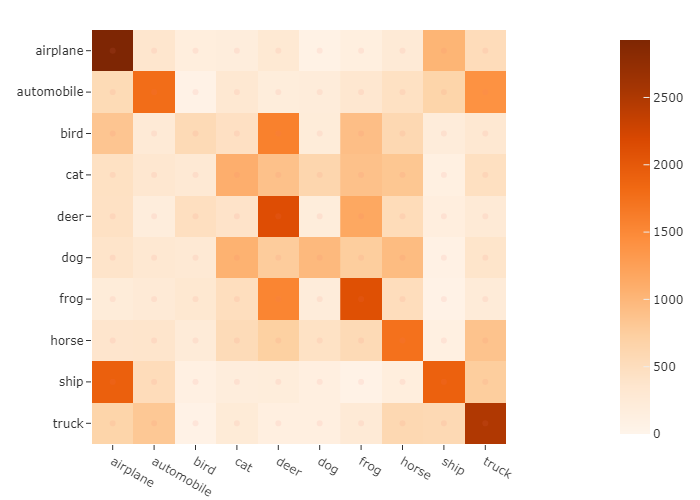

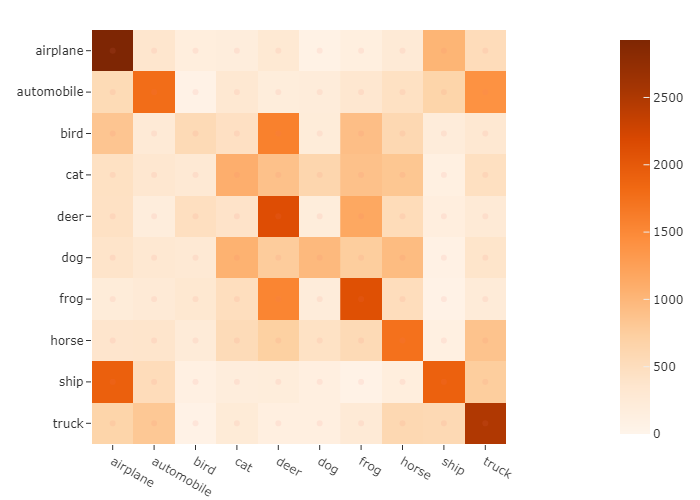

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': '7435e69d-5755-422a-a50f-7ebfdf7b0fa8',
              'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
                          4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
                          8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
                          2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
                          6, 7, 8, 9]),
              'y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
                          2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
                          4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
                          7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
    

In [31]:
plot = results.plot_confusion_matrix()
plot.show()

In [32]:
plot.freeze()  # replaces interactive plot with static image

In [33]:
# only binaryclassification
# plot = results.plot_pr_curve()
# plot.show()

In [34]:
# plot.freeze()  # replaces interactive plot with static image

In [35]:
print(dataset.count_values("eval"))

{False: 42296, True: 17704}


In [36]:
# cannot access to google driver

# fob.compute_uniqueness(dataset)

In [37]:
# Show most unique CORRECT predictions on validation split
# session.view = (
#     dataset
#     .match_tags("test")
#     .match(VF("predictions.label") == VF("ground_truth.label"))
#     .sort_by("uniqueness", reverse=True)
# )

In [38]:
# Show most unique INCORRECT predictions on validation split
# session.view = (
#     dataset
#     .match_tags("test")
#     .match(F("predictions.label") != F("ground_truth.label"))
    # .sort_by("uniqueness", reverse=True)
# )

In [39]:
fob.compute_hardness(dataset, "predictions")

Computing hardness...
 100% |█████████████| 60000/60000 [1.8m elapsed, 0s remaining, 550.5 samples/s]      
Hardness computation complete



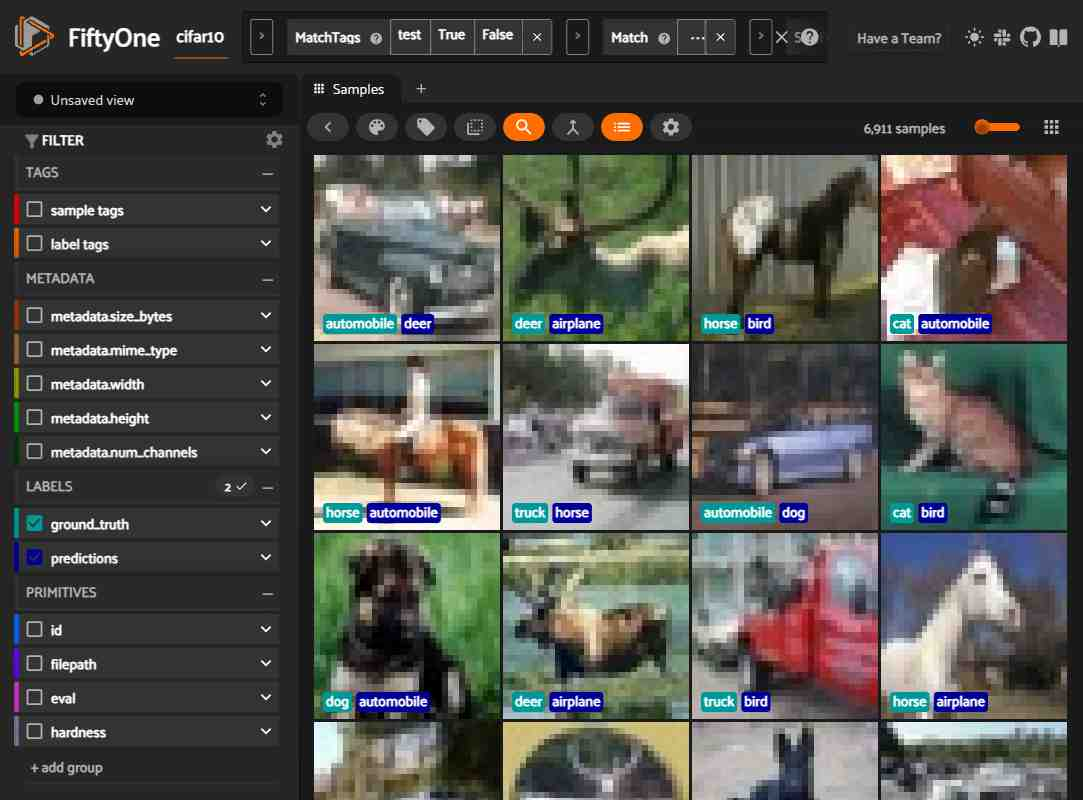

In [40]:
# Show the HARDEST FALSE on validation split
session.view = (
    dataset
    .match_tags("test")
    .match(VF("eval") == False)
    .sort_by("hardness", reverse=True)
)


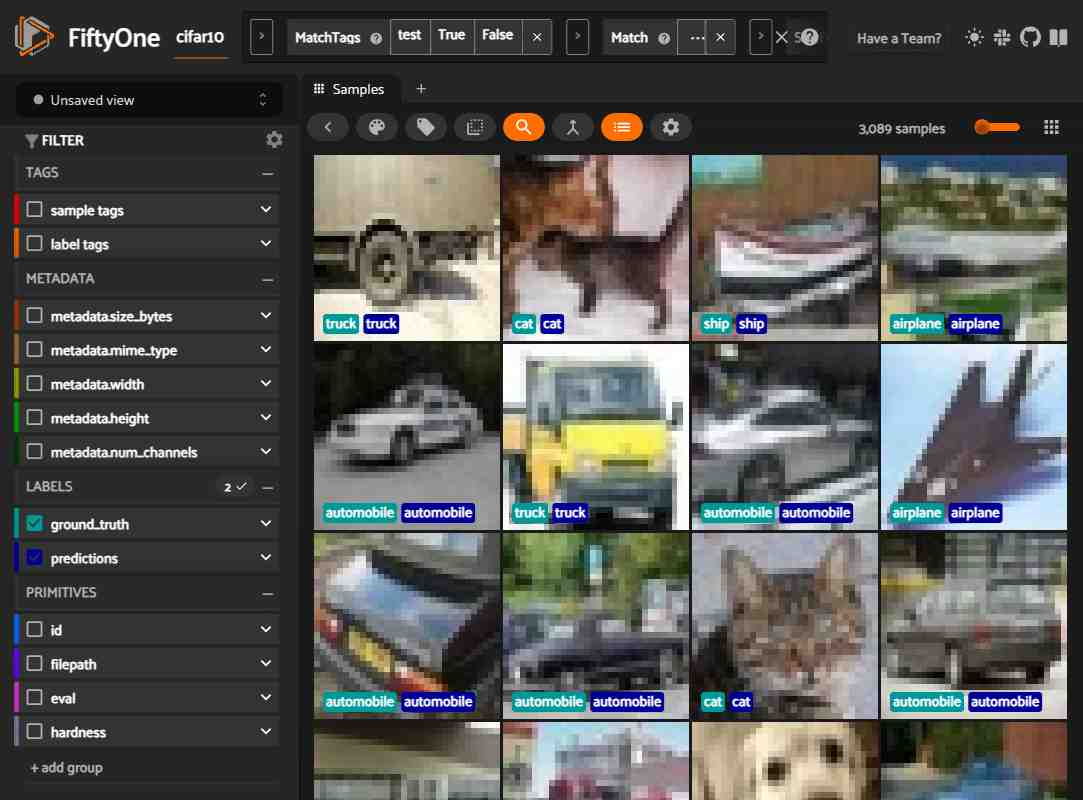

In [41]:
# Show the HARDEST RIGHT on validation split
session.view = (
    dataset
    .match_tags("test")
    .match(VF("eval") == True)
    .sort_by("hardness", reverse=True)
)

In [42]:
fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Computing mistakenness...
 100% |█████████████| 60000/60000 [2.0m elapsed, 0s remaining, 494.7 samples/s]      
Mistakenness computation complete


In [43]:
# Show the most likely ANNOTATION MISTAKES on the train split
session.view = (
    dataset
    .match_tags("train")
    .sort_by("mistakenness", reverse=True)
)

In [44]:
# Print stats about errors
train_f = dataset.match_tags("train").match(VF("eval") == False)
valid_f = dataset.match_tags("test").match(VF("eval") == False)

print("Train False: %d" % train_f.count())
print("Validation False: %d" % valid_f.count())

Train False: 35385
Validation False: 6911


In [45]:
# Export False samples to JSON
ERRORS_JSON_PATH = osp.join(work_dir, "errors.json")

errors = (
    dataset
    .match(VF("eval").is_in([False]))
    .set_field("ground_truth.logits", None)
    .set_field("predictions.logits", None)
)

errors.write_json(ERRORS_JSON_PATH, rel_dir=fifty_one_data_dir)

 100% |█████████████| 42296/42296 [27.8s elapsed, 0s remaining, 1.5K samples/s]      


### Well it's done!!!

# Reference

1. https://mmengine.readthedocs.io/zh_CN/latest/get_started/introduction.html
2. https://github.com/open-mmlab/mmengine/tree/main
3. https://github.com/voxel51/fiftyone
4. https://docs.voxel51.com/tutorials/detectron2.html
5. https://docs.voxel51.com/tutorials/evaluate_classifications.html
6. https://github.com/open-mmlab/mmengine-template/tree/main